This notebook trains a one layer CNN on the first derivative

In [8]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import heapq
import os
from datetime import datetime

In [9]:
# torch.cuda.is_available()

In [10]:
device = torch.device('cpu')

In [11]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [12]:
# For reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Generate dataset using the second derivative instead of the first

The code currently loads a previously created dataset instead of creating a new one each time.

In [13]:
class FourierSeriesDataset(Dataset):
    def __init__(self, num_samples, num_points, max_terms=10):
        self.num_samples = num_samples
        self.num_points = num_points
        self.max_terms = max_terms
        self.x = torch.linspace(0, 2*np.pi, num_points, requires_grad=True)
        self.functions, self.first_derivatives, self.second_derivatives = self.generate_data()

    def generate_data(self):
        functions = []
        first_derivatives = []
        second_derivatives = []

        for _ in range(self.num_samples):
            # Generate random complex coefficients
            n_terms = np.random.randint(1, self.max_terms + 1)
            c = torch.complex(torch.randn(2*n_terms+1), torch.randn(2*n_terms+1))

            # Compute function values
            y = self.complex_fourier_series(self.x, c)
            functions.append(y.detach().numpy())

            # Compute derivative
            dy_dx = torch.autograd.grad(y, self.x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
            first_derivatives.append(dy_dx.detach().numpy())

            d2y_dx2 = torch.autograd.grad(outputs=dy_dx, inputs=self.x, grad_outputs=torch.ones_like(dy_dx), create_graph=True)[0]
            second_derivatives.append(d2y_dx2.detach().numpy())

        return np.array(functions), np.array(first_derivatives), np.array(second_derivatives)

    def complex_fourier_series(self, x, c, P=2*np.pi):
        result = torch.zeros_like(x, dtype=torch.complex64)
        n_terms = (len(c) - 1) // 2
        for n in range(-n_terms, n_terms+1):
            result += c[n + len(c)//2] * torch.exp(1j * 2 * np.pi * n * x / P)
        return result.real

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return torch.FloatTensor(self.functions[idx]), torch.FloatTensor(self.first_derivatives[idx]), torch.FloatTensor(self.second_derivatives[idx])

# Generate dataset
num_samples = 10000
num_points = 1000

# Uncomment below to create dataset
# dataset = FourierSeriesDataset(num_samples, num_points)

# batch_size = 32
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# torch.save(dataset, 'datasets/both_derivatives_dataset.pt')

## Load previously saved dataset

In [14]:
# # When using the workstation:
dataset = torch.load('datasets/both_derivatives_dataset.pt')

# # When using the cluster:
# dataset = torch.load('both_derivatives_dataset.pt')

In [15]:
from torch.utils.data import random_split
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

In [17]:
print(len(train_dataloader))
print(len(test_dataloader))

250
62


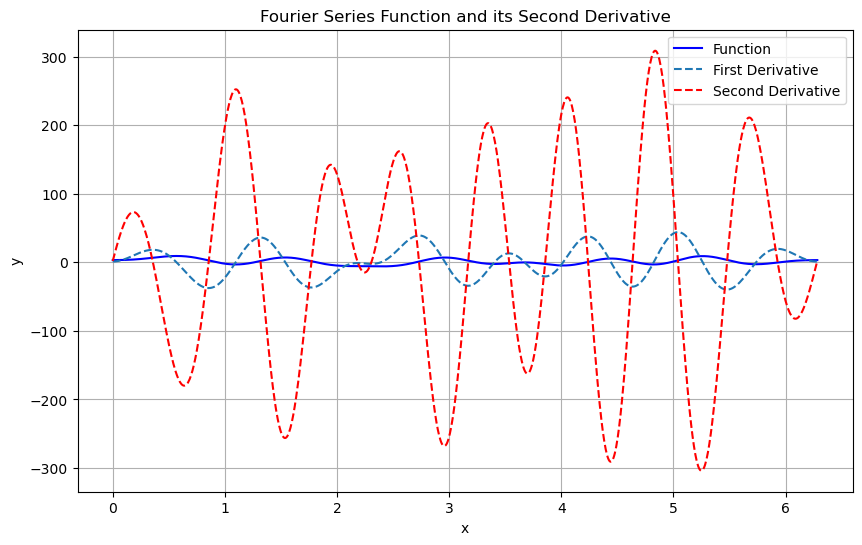

In [18]:
def plot_function_and_derivative(dataloader):
    # Get a single sample from the dataloader
    dataiter = iter(dataloader)
    function, derivative, second_derivative = next(dataiter)

    # Since we're dealing with batches, let's take the first item in the batch
    function = function[0].numpy()
    derivative = derivative[0].numpy()
    second_derivative = second_derivative[0].numpy()

    # Create x-axis values (assuming the domain is [0, 2π])
    x = torch.linspace(0, 2*torch.pi, len(function)).numpy()

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, function, label='Function', color='blue')
    plt.plot(x, derivative, label='First Derivative', linestyle='--')
    plt.plot(x, second_derivative, label='Second Derivative', color='red', linestyle='--')
    
    plt.title('Fourier Series Function and its Second Derivative')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    
    plt.show()

# Example usage:
# Assuming you have already created your dataset and dataloader as before
# dataset = FourierSeriesDataset(num_samples, num_points)

def get_random_function(shuffle=True):
    return DataLoader(train_dataset, batch_size=1, shuffle=shuffle)

train_dataloader_viz = get_random_function(shuffle=False)
plot_function_and_derivative(train_dataloader_viz)

## Model Training

Create the model

This version of the CNN uses 1 layer instead of three.

In [19]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 1, kernel_size=3, padding=1)
        # self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        # self.conv3 = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        # x = self.relu(self.conv2(x))
        # x = self.conv3(x)
        return x

# Initialize the model, loss function, and optimizer
model1 = SimpleCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model1.parameters(), lr=1e-3)

In [20]:
# to use model from cluster, use
model1.load_state_dict(torch.load('models/1000_epochs_first_derivative_weights.pth'))

<All keys matched successfully>

## Training loop

In [21]:
# Training loop
train_losses = []
test_losses = []

def model_training(num_epochs, order=None):
    for epoch in range(num_epochs):
        model1.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch_functions, batch_derivatives, batch_second_derivatives in train_dataloader:
            # Reshape input: [batch_size, 1, num_points]
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)
            batch_second_derivatives = batch_second_derivatives.unsqueeze(1)

            # Forward pass
            outputs = model1(batch_functions)
            loss = criterion(outputs, batch_derivatives)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model1.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives, b_test_second_derivatives in test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)
                b_test_second_derivatives = b_test_second_derivatives.unsqueeze(1)

                test_outputs = model1(b_test_functions)
                batch_test_loss = criterion(test_outputs, b_test_derivatives)

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    print(f"Training finished for {order} derivative")

In [22]:
# Uncomment below to train and save the model
# model_training(1000, order='first')
# torch.save(model1.state_dict(), 'models/1000_epochs_first_derivative_weights.pth')

In [23]:
def plot_losses(train_losses, test_losses, save_dir='plots', xmin=None, ymax=None, filename=None, save=False):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    current_date = datetime.now().strftime("%m-%d")
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, test_losses, linestyle='-', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"
    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)    
    plt.show()

In [24]:
# plot_losses(train_losses=train_losses, test_losses=test_losses, filename='first_derivative_loss_one_layer', save=True)

In [39]:
def plot_output(model1, order=None, save_dir='plots', filename=None, save=False): 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    current_date = datetime.now().strftime("%m-%d")
    model1.eval()  # Set the model to evaluation mode

    train_dataloader_viz = get_random_function(shuffle=True)
    # Get a random sample from the dataloader
    dataiter = iter(train_dataloader_viz)
    function, true_derivative, true_second_derivative = next(dataiter)

    # Reshape the input for the model
    function = function.unsqueeze(1)  # Add channel dimension

    # Make prediction
    with torch.no_grad():
        if order == 1 or order == 2:
            predicted_derivative = model1(function)
        
        if order == 'rollout':
            predicted_derivative = model1(function)
            predicted_derivative = model1(predicted_derivative)

    # Convert tensors to numpy arrays for plotting
    x = torch.linspace(0, 2*torch.pi, 1000).numpy()
    function = function.squeeze().numpy()

    predicted_derivative = predicted_derivative.squeeze().numpy()

    true_derivative = true_derivative.squeeze().numpy()
    true_second_derivative = true_second_derivative.squeeze().numpy()

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.plot(x, function, label='Original Function', color='blue')
    if order == 1:
        plt.plot(x, true_derivative, label=f'True {order} derivative')
    if order == 2:
        plt.plot(x, true_second_derivative, label=f'True {order} derivative')

    plt.plot(x[10:-10], predicted_derivative[10:-10], label=f'Predicted {order} Derivative', linestyle='--')

    plt.title('Function, True Derivatives, and Predicted Derivatives')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"

    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)  
    plt.show()

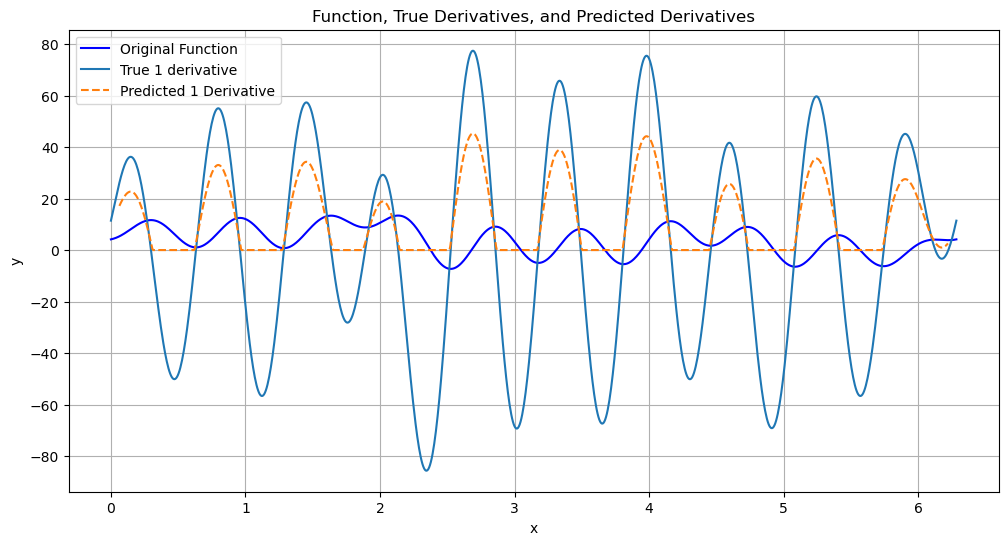

In [42]:
plot_output(model1, order=1, save_dir='plots', filename='first_derivative_output_one_layer', save=True)

## Calculate accuracy (MSE)

In [43]:
def calculate_combined_output(model1, model2, function_input, true_derivative):
    # Predict the derivative from the first model
    predicted_derivative1 = model1(function_input)

    # Compute the residual and root mean squared error
    residual = predicted_derivative1.squeeze() - true_derivative
    rms = torch.sqrt(torch.mean(residual**2))

    # Predict the derivative from the second model
    predicted_derivative2 = model2(function_input)

    # Calculate the combined model output
    combined_model_output = predicted_derivative1 + rms * predicted_derivative2

    return combined_model_output

In [60]:
def compute_mse(dataloader, model1, model2=None):
    all_outputs = []
    all_targets = []

    for function, deriv, second_deriv in dataloader:
        function = function.unsqueeze(1)
        deriv = deriv.unsqueeze(1)
        second_deriv = second_deriv.unsqueeze(1)

        # Compute model output
        if model2:
            model_output = calculate_combined_output(model1, model2, function, deriv)
            all_targets.append(second_deriv)
        else:
            model_output = model1(function)
            all_targets.append(deriv)

        # Collect outputs
        all_outputs.append(model_output)

    # Concatenate all collected outputs and targets
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute MSE
    mse = torch.mean((all_outputs - all_targets) ** 2)
    print(f"Overall MSE over all test functions: {mse.item()}")
    return mse.item()
compute_mse_batch(test_dataloader, model1)

Overall MSE over all test functions: 160.81289672851562


160.81289672851562

## Normalized MSE

In [61]:
def compute_nmse(dataloader, model1, model2=None):
    all_outputs = []
    all_targets = []

    for function, deriv, second_deriv in dataloader:
        function = function.unsqueeze(1)
        deriv = deriv.unsqueeze(1)
        second_deriv = second_deriv.unsqueeze(1)

        # Compute model output
        if model2:
            model_output = calculate_combined_output(model1, model2, function, deriv)
            all_targets.append(second_deriv)
        else:
            model_output = model1(function)
            all_targets.append(deriv)

        # Collect outputs
        all_outputs.append(model_output)

    # Concatenate all collected outputs and targets
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute MSE
    mse = torch.mean((all_outputs - all_targets) ** 2 / (all_targets ** 2))
    print(f"Overall MSE over all test functions: {mse.item()}")
    return mse.item()
compute_nmse(test_dataloader, model1)

Overall MSE over all test functions: 5565309.5


5565309.5

## Spectral biases from Fourier Transform

In [62]:
def calculate_median_frequency(function):
    fft_coeffs = np.fft.fft(function)
    freqs = np.fft.fftfreq(len(function))
    power_spectrum = np.abs(fft_coeffs)**2
    significant_freqs = freqs[power_spectrum > (np.max(power_spectrum) * 0.01)]
    return np.median(np.abs(significant_freqs))

def categorize_functions(dataloader):
    functions_with_freqs = []
    
    for functions, derivatives, sec_derivative in dataloader:
        for idx, function in enumerate(functions):
            median_frequency = calculate_median_frequency(function.numpy())
            functions_with_freqs.append((function.numpy(), derivatives[idx].numpy(), sec_derivative[idx].numpy(), median_frequency))
    
    # Sort by median frequency
    functions_with_freqs.sort(key=lambda x: x[3])
    
    # Split into low and high frequency datasets
    mid_index = len(functions_with_freqs) // 2
    low_freq_dataset = functions_with_freqs[:mid_index]
    high_freq_dataset = functions_with_freqs[mid_index:]
    
    # Create new DataLoaders, excluding the median frequency from the data
    # Each dataloader contains the function, deriv, and second deriv
    low_freq_dataloader = DataLoader([(f[0], f[1], f[2]) for f in low_freq_dataset])
    high_freq_dataloader = DataLoader([(f[0], f[1], f[2]) for f in high_freq_dataset])
    
    return low_freq_dataloader, high_freq_dataloader

In [63]:
# use the test dataset to compute frequencies
# Should be half of full dataset in each dataloader
low_freq_dataset, high_freq_dataset = categorize_functions(test_dataloader)

print(f"Low frequency dataset size: {len(low_freq_dataset)}")
print(f"High frequency dataset size: {len(high_freq_dataset)}")

Low frequency dataset size: 992
High frequency dataset size: 992


In [64]:
low_freq_mse = compute_mse(low_freq_dataset, model1)
low_freq_nmse = compute_nmse(low_freq_dataset, model1)

Overall MSE over all test functions: 42.92215347290039
Overall MSE over all test functions: 9705279.0


In [65]:
high_freq_mse = compute_mse(high_freq_dataset, model1)
high_freq_nmse = compute_nmse(high_freq_dataset, model1)

Overall MSE over all test functions: 278.7036437988281
Overall MSE over all test functions: 1425323.375
